# Data Augmentation - Synonym Replacement

In [1]:
import pandas as pd
import re
import random
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from random import randint
import nltk.data
from nltk import pos_tag
import matplotlib.pyplot as plt
import seaborn as sns


Load the data set 

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Clean the Data

In [3]:
def clean_text(text):
    """Function to clean the text from noise, with the option to remove stopwords
    """
    # regex to remove all Non-Alpha Numeric and space
    special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
    # regex to replace all numeric
    replace_numbers=re.compile(r'\d+',re.IGNORECASE)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"'", " ", text)
    text = replace_numbers.sub('', text)
    text = str(text).replace("\n", " ")
    text = str(text).replace("   ", " ")
    text = special_character_removal.sub('',text)
    return text

In [4]:
data['comment_text'] = [clean_text(comment) for comment in data['comment_text'].to_list()]

In [5]:
sev_tox_data = data[(data['severe_toxic'] == 1)]
obs_data = data[(data['obscene'] == 1)]
threat_data = data[(data['threat'] == 1)]
insult_data = data[(data['insult'] == 1)]
identity_data = data[(data['identity_hate'] == 1)]
non_toxic_data = data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)]



Load WordNet

In [6]:
from nltk.corpus import wordnet
syns = wordnet.synsets("dog")
print(syns)

[Synset('dog.n.01'), Synset('frump.n.01'), Synset('dog.n.03'), Synset('cad.n.01'), Synset('frank.n.02'), Synset('pawl.n.01'), Synset('andiron.n.01'), Synset('chase.v.01')]


In [ ]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')

Replace words in comments with random synonyms

In [7]:
comments = ["Pete ate a large cake. Sam has a big mouth.",
            "The sun is shining in the middle of the night",
            "Pizza is the best way to forget about your hang over"]
output = ""

def prepare(comment):
    words = word_tokenize(comment)    
    tagged = nltk.pos_tag(words)    
    return words, tagged

def get_rand_ints(comment):
        amount = len(comment) // 4
        randomliste = [random.randrange(0, len(comment), 3) for i in range(amount)]
        return randomliste

def check_for_stopwords(randomliste, words):
    new_list = []
    for n in randomliste:
        stop_words = get_stop_words('english')
        while words[n] in stop_words:
            n = n - 1
        new_list.append(n)
        return new_list    
        
          
def synonym_replacement(words, tagged):
    output = ""
    for i in range(0,len(words)):
        new_words = []
        replacements = []
        for syn in wn.synsets(words[i]):
            if tagged[i][1] == 'NNP' or tagged[i][1] == 'DT':
                break
            word_type = tagged[i][1][0].lower()
            if syn.name().find("."+word_type+"."):
                r = syn.name()[0:syn.name().find(".")]
                replacements.append(r)
        if len(replacements) > 0:
            replacement = replacements[randint(0,len(replacements)-1)]
            output = output + " " + replacement
        else:
            output = output + " " + words[i]
        new_words.append(output)
    new_com = ' '.join(new_words)
    return new_com

In [8]:
def get_series_list(new_com, series_list):
    new_row = ['NaN', new_com, 0, 0, 0, 0, 0, 1]
    series_list.append(new_row)
    return series_list

Create a dataframe for the new comments and add them to the rest

Add comments to identity_hate class

In [9]:
series_list = []
for comment in identity_data.comment_text:
    words, tagged = prepare(comment)
    new_com = synonym_replacement(words, tagged)
    series_list = get_series_list(new_com, series_list)
aug_only_data = pd.DataFrame(series_list, columns=data.columns)    
old_and_aug_data = pd.concat([data, aug_only_data], ignore_index=True)

Add comments to threat class

In [10]:
def get_series_list(new_com, series_list):
    new_row = ['NaN', new_com, 0, 0, 0, 1, 0, 0]
    series_list.append(new_row)
    return series_list

In [11]:
series_list = []
for comment in threat_data.comment_text:
    words, tagged = prepare(comment)
    new_com = synonym_replacement(words, tagged)
    series_list = get_series_list(new_com, series_list)
aug_only_data = pd.DataFrame(series_list, columns=data.columns)    
old_and_aug_data = pd.concat([data, aug_only_data], ignore_index=True)

Add comments to severe_toxic class

In [24]:
def get_series_list(new_com, series_list):
    new_row = ['NaN', new_com, 0, 1, 0, 0, 0, 0]
    series_list.append(new_row)
    return series_list

In [25]:
series_list = []
for comment in sev_tox_data.comment_text:
    words, tagged = prepare(comment)
    new_com = synonym_replacement(words, tagged)
    series_list = get_series_list(new_com, series_list)
aug_only_data = pd.DataFrame(series_list, columns=data.columns)    
old_and_aug_data = pd.concat([data, aug_only_data], ignore_index=True)

Plot the number of comments, to check how our data frame has grown.

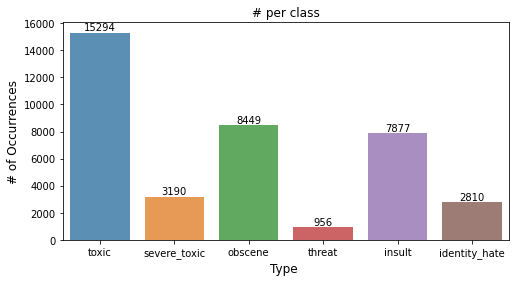

In [29]:
x=data.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)


rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Save data to new CSV File

In [30]:
data.to_csv('train_synonyms_replaced.csv')

# Data Augmentation #2 - Adding new comments

Another way of augmenting our data to tackle the imbalance within the small classes, we added comments from a differet Kaggle Challenge (Unintended Bias in Toxicity Classification)

In [18]:
new_df = pd.read_csv('data/extra_train.csv')

To minimize the data set and augment only the classes that needed augmentation, a few filters have been used. We started with only using the approved comments. 

In [ ]:
new_data = new_df[new_df['rating'] == 'approved']

All the extra columns needed to be dropped.

In [19]:
new_data.columns

NameError: name 'new_data' is not defined

In [ ]:
cols_to_keep = ['id', 'comment_text', 'target', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']

In [ ]:
new_df = new_data[cols_to_keep]

In [104]:
new_df.head()

,id,comment_text,target,severe_toxicity,obscene,threat,insult,identity_attack
8,239575,The ranchers seem motivated by mostly by greed...,0.00,0.0,0.000000,0.0,0.00,0.0
9,239576,It was a great show. Not a combo I'd of expect...,0.00,0.0,0.000000,0.0,0.00,0.0
10,239578,"Wow, that sounds great.",0.00,0.0,0.000000,0.0,0.00,0.0
11,239579,This is a great story. Man. I wonder if the pe...,0.44,0.0,0.293333,0.0,0.32,0.0
12,239582,This seems like a step in the right direction.,0.00,0.0,0.000000,0.0,0.00,0.0


The new data set looked a bit different to the old one, the 'target' variable caclulated a score to indicate the toxicity. Since we were only interested in getting more toxic comments (instead of more non-toxic), we filtered the comments, so that we only kept the comments with a value greater than 0.

In [20]:
new_df = new_df[new_df['target'] > 0]

In [10]:
new_df.shape

(472533, 8)

The classes were anotated in a different way in this data set. Instead of a binary outcome for every class, the data set contains a mean value of all the anotater's decisions. To get a binary value, more than half of the anotators needed to classify the comment as  belonging to a class. Hence, comments with a value greater than 0.5 were assigned the value 1, other te value 0. Additionally, the labels were renamed according to the classes in th eold data set.

In [11]:
target_list = new_df['target'].to_list()

new_df['toxic'] = [1 if x > 0.5 else 0 for x in target_list]

In [12]:
new_df.drop('target', axis = 1, inplace = True)

In [13]:
severe_toxic_list = new_df['severe_toxicity'].to_list()
new_df['severe_toxic'] = [1 if x > 0.5 else 0 for x in severe_toxic_list]

In [14]:
new_df.drop('severe_toxicity', axis = 1, inplace = True)

In [15]:
obscene_list = new_df['obscene'].to_list()
new_df['obscene_new'] = [1 if x > 0.5 else 0 for x in obscene_list]

In [16]:
new_df.drop('obscene', axis = 1, inplace = True)

In [17]:
threat_list = new_df['threat'].to_list()
new_df['threat_new'] = [1 if x > 0.5 else 0 for x in threat_list]

In [18]:
new_df.drop('threat', axis = 1, inplace = True)

In [19]:
insult_list = new_df['insult'].to_list()
new_df['insult_new'] = [1 if x > 0.5 else 0 for x in insult_list]

In [20]:
new_df.drop('insult', axis = 1, inplace = True)

In [21]:
identity_list = new_df['identity_attack'].to_list()
new_df['identity_hate'] = [1 if x > 0.5 else 0 for x in identity_list]

In [22]:
new_df.drop('identity_attack', axis = 1, inplace=True)

In [23]:
cols = {'obscene_new':'obscene', 'threat_new':'threat', 'insult_new':'insult'}

new_df.rename(columns=cols, inplace=True)

Plot the new data to get an idea of how many comments we gain, with this method. 

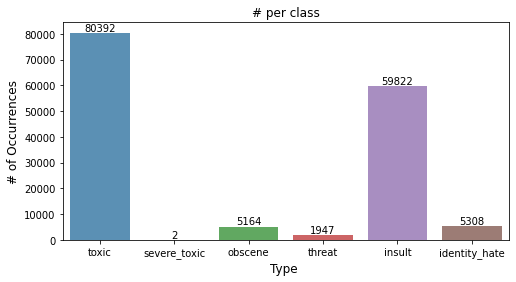

In [24]:
x=new_df.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)


rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Now lets add the comments of the 'small' classes to our old data frame. 

In [25]:
new_data = new_df.query('severe_toxic == 1 or threat == 1 or identity_hate == 1')

After filtering for our new classes, this plot shows how many comments we gain.

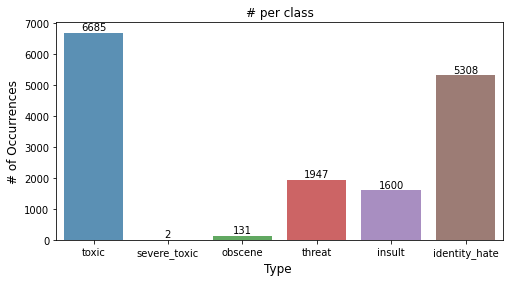

In [26]:
x=new_data.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)


rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [133]:
old_df = pd.read_csv('data/train.csv')

Let's save the new comments only, just to have them in our back up. 

In [29]:
new_data.to_csv('data/new_coms.csv')

Concatenate old and new to get brand new. 

In [136]:
all_data = pd.concat([old_df, new_data], ignore_index=True)

Let's take a look at the number of comments in the concatenated data frame. 

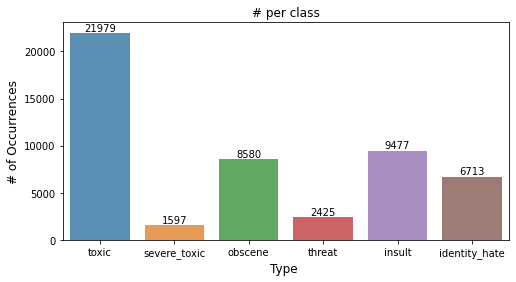

In [140]:
x=all_data.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)


rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Save new data frame in a csv file. 

In [141]:
all_data.to_csv('data/rich_train.csv')